In [1]:
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy
from astropy import wcs
from astroquery.ned import Ned
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
import matplotlib as mat
mat.cmap = mat.cm.jet
from astropy.stats import median_absolute_deviation as MAD
from sklearn.linear_model import RANSACRegressor
from sklearn.datasets import make_regression
import scipy.ndimage as ndi
import make_astro_map as mam

folder = "C:/Users/emily/Documents/ARC Summer 2019/"
ims = folder+"Images/"
fts = folder+"FITS files/"
label = "A"

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


In [2]:
wide_band_file = "C:/Users/emily/Documents/ARC Summer 2019/FITS files/NGC_4261_hst_10882_01_acs_wfc_fr647m_01_drz.fits"
narrow_band_file = "C:/Users/emily/Documents/ARC Summer 2019/FITS files/NGC_4261_hst_10882_01_acs_wfc_fr656n_01_drz.fits"
#corr_data = subtract_continuum(wide_band_file, narrow_band_file)

In [3]:
with fits.open(wide_band_file) as wbf:
    wide_band_hdr = wbf[0].header
    wide_band = wbf[0].data*wide_band_hdr['photflam']
with fits.open(narrow_band_file) as nbf:
    narrow_band_hdr = nbf[0].header
    narrow_band = nbf[0].data*narrow_band_hdr['photflam']

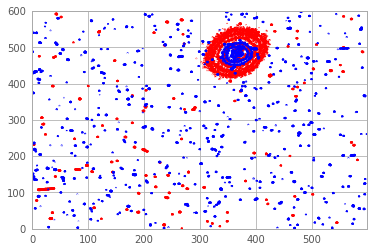

In [4]:
plt.contour(wide_band[1300:1900,1300:1900], colors='red', levels=np.percentile(wide_band[np.where(wide_band !=0)],np.arange(99.5,99.9,0.1)))
plt.contour(narrow_band[1300:1900,1300:1900], colors='blue', levels=np.percentile(narrow_band[np.where(narrow_band!=0)],np.arange(99.5,99.9,0.1)))
plt.savefig("C:/Users/emily/Documents/ARC Summer 2019/NGC4261_w_n_band_centers")

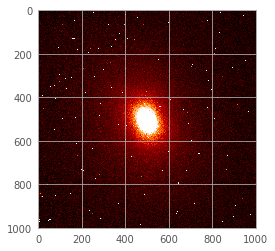

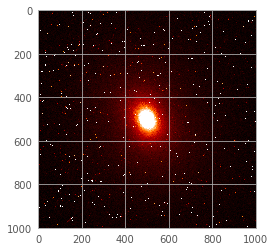

In [5]:
wcs_wide=wcs.WCS(wide_band_hdr)

result_table = Ned.query_object('NGC 4261')

ra = result_table['RA'][0]
dec = result_table['DEC'][0]
delta = 500

center_w = wcs_wide.wcs_world2pix(ra, dec, 0)\

xw = int(center_w[0])+127
yw = int(center_w[1])-165

wide_band_crop = wide_band[xw-delta:xw+delta,yw-delta:yw+delta]
narrow_band_crop = narrow_band[xw-delta:xw+delta,yw-delta:yw+delta]

plt.imshow(wide_band_crop, vmin=np.percentile(wide_band_crop, 1), vmax=np.percentile(wide_band_crop, 99))
plt.show()
plt.imshow(narrow_band_crop, vmin=np.percentile(narrow_band_crop, 1), vmax=np.percentile(narrow_band_crop, 99))
plt.show()

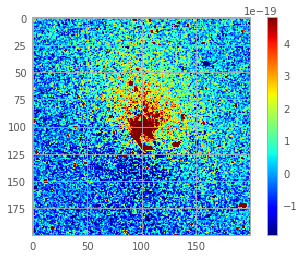

In [6]:
subtracted = narrow_band_crop-wide_band_crop
plt.imshow(subtracted[400:600,400:600], vmin=np.percentile(subtracted, 1), vmax=np.percentile(subtracted, 99), cmap=mat.cm.jet)
plt.colorbar()
#plt.savefig("C:/Users/emily/Documents/ARC Summer 2019/NGC4261_subtracted.png")

In [7]:
# the version that works
r_inner = 40
r_outer = 80

y = np.arange(wide_band_crop.shape[0])
x = np.arange(wide_band_crop.shape[1])

xx, yy = np.meshgrid(x, y)

c1 = (xx-delta)**2 + (yy-delta)**2 > r_inner**2
c2 = (xx-delta)**2 + (yy-delta)**2 < r_outer**2
z = c1*c2

narrow_band_pixels = z*narrow_band_crop
wide_band_pixels = z*wide_band_crop
            
X = wide_band_pixels[np.nonzero(wide_band_pixels)].reshape(-1,1)
Y = narrow_band_pixels[np.nonzero(narrow_band_pixels)].reshape(-1,1)

0.8800035119056702 1.2796096335283204e-19


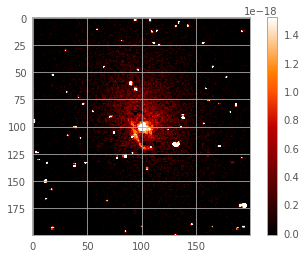

In [8]:
reg = RANSACRegressor(random_state=0).fit(X, Y)
a = float(reg.estimator_.coef_)
b = float(reg.estimator_.intercept_)
print(a,b)
subtracted = narrow_band_crop-a*wide_band_crop-b*np.ones(wide_band_crop.shape)
plt.imshow(subtracted[400:600,400:600], vmin=np.percentile(narrow_band_crop, 1), vmax=np.percentile(narrow_band_crop, 99))
plt.colorbar()
#plt.savefig("C:/Users/emily/Documents/ARC Summer 2019/NGC4261_RANSAC_subtracted.png")

outliers:  0.13154746078170698


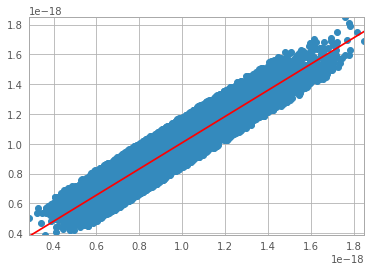

In [9]:
galaxy = "NGC4261"
X_in = X[reg.inlier_mask_]
Y_in = Y[reg.inlier_mask_]
plt.scatter(X_in, Y_in)
plt.plot([0,1], [b, a+b], 'r')
plt.axis([X_in.min(), X_in.max(), Y_in.min(), Y_in.max()])
print("outliers: ", 1-reg.inlier_mask_.sum()/reg.inlier_mask_.size)
#plt.savefig("C:/Users/emily/Documents/ARC Summer 2019/Images/"+galaxy+"_fit.png")
plt.show()

In [10]:
w_2 = 2
subtracted_2 = np.zeros(subtracted.shape)

for y in range(w_2, subtracted.shape[0]-w_2):
    for x in range(w_2, subtracted.shape[1]-w_2):
        avg = 0.0
        for i in range(-w_2, w_2):
            for j in range(-w_2, w_2):
                avg = avg + subtracted[x+i,y+j]/(w_2*2.0)**2.0
        subtracted_2[x,y] = avg

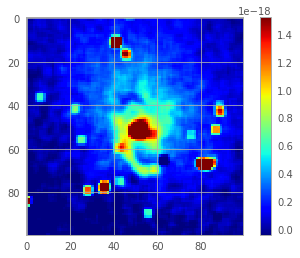

In [11]:
plt.imshow(subtracted_2[450:550,450:550], vmin=np.percentile(narrow_band_crop, .1), vmax=np.percentile(narrow_band_crop, 99), cmap=mat.cm.jet)
plt.colorbar()

In [12]:
full_image = subtracted*narrow_band_hdr['photbw']
hdr = narrow_band_hdr
hdr['CRPIX1'] = delta
hdr['CRPIX2'] = delta
hdr['CRVAL1'] = ra
hdr['CRVAL2'] = dec
hdr['ra_aper'] = ra
hdr['dec_aper'] = dec
hdr['bunit'] = 'erg/s/cm2'
hdr['goodmin'] = np.percentile(full_image, 10)
hdr['goodmax'] = np.percentile(full_image, 99.5)
hdr.set('target', 'NGC4261', 'target name')

hdu = fits.PrimaryHDU(data=full_image, header=hdr)
#hdu.writeto("C:/Users/emily/Documents/ARC Summer 2019/FITS files/Subtracted/"+galaxy+"_subtracted.fits")

5
[100 300 500 700 900]
['-20', '-10', '0', '10', '20']
5
[100 300 500 700 900]
['-20', '-10', '0', '10', '20']


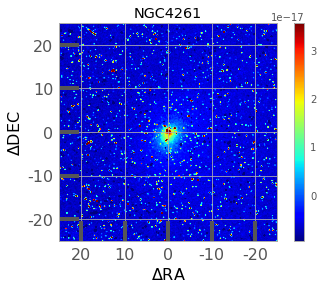

In [13]:
plt.clf()
h_img = ndi.gaussian_filter(full_image, 2.0)
hmin = np.percentile(full_image, 10)
hmax = np.percentile(full_image, 99.25)

#plt.imshow(h_img, vmin=hmin, vmax=hmax, cmap=mat.cm.jet)
ax1,extw1,w1=mam.make_plot(full_image,hdr,dval=10.01,cmap=mat.cm.jet,vmin=-1e-17,vmax=7e-17)
mam.make_plot(h_img,hdr,dval=10.01,cmap=mat.cm.jet,vmin=hmin, vmax=hmax)
plt.colorbar()
plt.title(galaxy)
plt.show()
#plt.savefig(ims+"final/"+galaxy+"_Ha.jpg", bbox_inches = 'tight')

In [14]:
#plt.savefig(ims+"final/"+galaxy+"_Ha.jpg", bbox_inches = 'tight')

Flux correction:  -4.218099699113099e-18


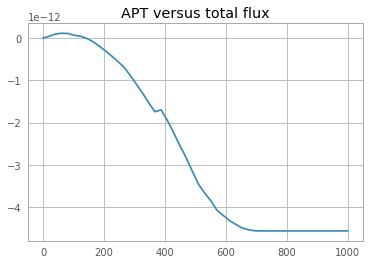

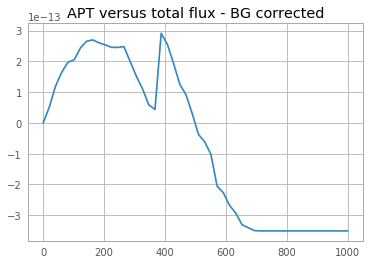

Galactic flux: 2.695846762774953e-13 pixel value: 163


In [15]:
# summing up the image for the total flux

fluxes = []
fluxes_corr = []

pix = np.linspace(0, full_image.shape[0], num=50)

for r in pix:
    z = (xx-delta)**2+(yy-delta)**2<r**2
    flux = (z*full_image).sum()
    fluxes.append(flux)

R = int(full_image.shape[0]/2)
z = (xx-delta)**2+(yy-delta)**2<R**2
f_bg = (z*full_image).sum()/np.pi/R**2
print("Flux correction: ", f_bg)

bg_corr = full_image - f_bg*np.ones(full_image.shape)

for r in pix:
    z = (xx-delta)**2+(yy-delta)**2<r**2
    flux_corr = (z*bg_corr).sum()
    fluxes_corr.append(flux_corr)
    
plt.plot(pix, fluxes)
plt.title("APT versus total flux")
plt.show()
plt.plot(pix, fluxes_corr)
plt.title("APT versus total flux - BG corrected")
plt.show()
f = max(fluxes_corr[0:15])
apt = int(pix[fluxes_corr.index(f)])
print("Galactic flux:", f, "pixel value:", apt)

MAD: 2.6830073650430485e-18 , Error:  7.751475979970813e-16
Std:  1.8721460855641198e-16 , Error:  5.408816838269773e-14
% of image:  0.125588


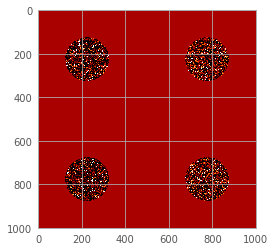

In [16]:
# calculate standard deviation
w = 100
offset = 275

z1 = (xx-delta-offset)**2+(yy-delta-offset)**2 < w**2
z2 = (xx-delta+offset)**2+(yy-delta-offset)**2 < w**2
z3 = (xx-delta+offset)**2+(yy-delta+offset)**2 < w**2
z4 = (xx-delta-offset)**2+(yy-delta+offset)**2 < w**2
z = z1+z2+z3+z4

noise_pixels = (z*bg_corr).flatten()
noise_pixels = noise_pixels[np.where(noise_pixels!=0)]

apt_size = np.pi*(apt**2)

k = 1.4826
mad = k*MAD(noise_pixels)
std = np.std(noise_pixels)
plt.imshow(z*bg_corr, vmin=np.percentile(bg_corr, 30), vmax=np.percentile(bg_corr, 95))
print("MAD:", mad, ", Error: ", mad*np.sqrt(apt_size))
print("Std: ", std, ", Error: ", std*np.sqrt(apt_size))
print("% of image: ", z.sum()/full_image.shape[0]**2)

In [17]:
# Calculate systematic error

a_err = mad / (X_in.std()*np.sqrt(len(X_in)+1))
b_err = mad * np.sqrt((X_in**2).mean())/(X_in.std()*np.sqrt(len(X_in)+1))

print("Slope error: ", a_err, ", Intercept error: ", b_err)

z = (xx-delta)**2+(yy-delta)**2<apt**2
wide_ap = (z*wide_band_crop).sum()
sys_err = np.sqrt((a_err* wide_ap)**2 + (z.sum()*b_err)**2)

print("Systematic error: ", sys_err, ",", sys_err/f*100, "%")

Slope error:  0.09378573699582386 , Intercept error:  8.642854932994645e-20
Systematic error:  8.520427904164684e-15 , 3.160575750008222 %


[99.0, 99.2475, 99.495, 99.74249999999999, 99.99]


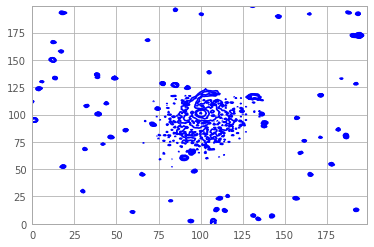

In [18]:
# contour subtracted flux
nums = np.linspace(99, 99.99, num=5)
nums = list(nums)
#nums.insert(0, 99.5)
#nums.insert(0, 99)
print(nums)
plt.contour(full_image[400:600,400:600], colors='blue', levels=np.percentile(full_image,nums))

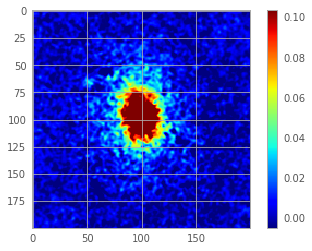

In [19]:
%matplotlib inline
dust_file = "C:/Users/emily/Documents/ARC Summer 2019/FITS files/Dust/NGC4261_dust_colorsub_smoothed.fits"
with fits.open(dust_file) as df:
    dust_hdr = df[1].header
    dust = df[1].data
    
dust_img = -ndi.gaussian_filter(dust, 1)
dustmin = np.percentile(dust_img, 5)
dustmax = np.percentile(dust_img, 99.6)
    
plt.imshow(dust_img[250:450, 250:450], vmin=dustmin, vmax=dustmax, cmap=mat.cm.jet)
plt.colorbar()

In [29]:
#Contour the H_a
%matplotlib qt

y = np.arange(h_img.shape[0])
x = np.arange(h_img.shape[1])

xx, yy = np.meshgrid(x, y)
z = (xx-500)**2+(yy-500)**2 < 75**2

nums = [.5e-17, 2e-17, 1e-16]

ax1,extw1,w1=mam.make_plot(h_img,hdr,dval=5.01,cmap=mat.cm.jet,vmin=hmin,vmax=hmax)
ax2,extw2,w2=mam.make_plot(dust_img,dust_hdr,dval=5.01,cmap=mat.cm.jet,vmin=dustmin,vmax=dustmax)

mam.make_plot(dust_img,dust_hdr,dval=5.01,cmap=mat.cm.jet,vmin=dustmin, vmax=dustmax)
#mam.make_plot(ndi.gaussian_filter(full_image,3.0),hdr,dval=10.01,cmap=mat.cm.jet,vmin=np.percentile(full_image, 1), vmax=np.percentile(full_image, 99.5))

plt.contour(h_img*z,extent=extw1,levels=nums,colors='w', linewidths=4)
plt.show()
#plt.savefig(ims+galaxy+"_Ha_on_dust_contour.jpg", bbox_inches = 'tight')

9
[ 99 199 300 400 500 600 700 801 901]
['-20', '-15', '-10', '-5', '0', '5', '10', '15', '20']
13
[ 49  99 150 200 250 300 350 400 450 500 550 601 651]
['-30', '-25', '-20', '-15', '-10', '-5', '0', '5', '10', '15', '20', '25', '30']
13
[ 49  99 150 200 250 300 350 400 450 500 550 601 651]
['-30', '-25', '-20', '-15', '-10', '-5', '0', '5', '10', '15', '20', '25', '30']


In [30]:
#plt.savefig(ims+"final/"+galaxy+"_Ha_on_dust_contour.jpg", bbox_inches = 'tight')

In [27]:
# Contour the dust images
%matplotlib qt
plt.clf()
nums = [.05, .15, .32, .9]
ax1,extw1,w1=mam.make_plot(h_img,hdr,dval=5.01,cmap=mat.cm.jet,vmin=hmin,vmax=hmax)
ax2,extw2,w2=mam.make_plot(dust_img,dust_hdr,dval=5.01,cmap=mat.cm.jet,vmin=dustmin,vmax=dustmax)

#mam.make_plot(dust_img,dust_hdr,dval=10.01,cmap=mat.cm.jet,vmin=dustmin, vmax=dustmax)
mam.make_plot(h_img,hdr,dval=5.01,cmap=mat.cm.jet,vmin=hmin, vmax=hmax)

plt.contour(dust_img,extent=extw2,levels=nums,colors='w',linewidths=4)
plt.show()
#plt.savefig(ims+"final/"+galaxy+"_dust_on_Ha_contour.jpg")

9
[ 99 199 300 400 500 600 700 801 901]
['-20', '-15', '-10', '-5', '0', '5', '10', '15', '20']
13
[ 49  99 150 200 250 300 350 400 450 500 550 601 651]
['-30', '-25', '-20', '-15', '-10', '-5', '0', '5', '10', '15', '20', '25', '30']
9
[ 99 199 300 400 500 600 700 801 901]
['-20', '-15', '-10', '-5', '0', '5', '10', '15', '20']


In [28]:
#plt.savefig(ims+"final/"+galaxy+"_dust_on_Ha_contour.jpg", bbox_inches='tight')